In [3]:
print('hey')

hey


In [5]:
!pip install biopython openpyxl

DEPRECATION: Loading egg at /usr/local/lib/python3.12/dist-packages/opt_einsum-3.4.0-py3.12.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /usr/local/lib/python3.12/dist-packages/nvfuser-0.2.23a0+6627725-py3.12-linux-x86_64.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /usr/local/lib/python3.12/dist-packages/lightning_utilities-0.12.0.dev0-py3.12.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /usr/local/lib/python3.12/dist-packages/dill-0.3.9-py3.12.egg is deprecated

In [6]:
from Bio import SeqIO
import gzip
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import seaborn as sns
from sklearn.metrics import roc_auc_score

In [7]:
brca1_df = pd.read_excel(
    os.path.join('brca1', '41586_2018_461_MOESM3_ESM.xlsx'),
    header=2,
)
brca1_df = brca1_df[[
    'chromosome', 'position (hg19)', 'reference', 'alt', 'function.score.mean', 'func.class',
]]

brca1_df.head(10)

,chromosome,position (hg19),reference,alt,function.score.mean,func.class
0,17,41276135,T,G,-0.372611,FUNC
1,17,41276135,T,C,-0.045313,FUNC
2,17,41276135,T,A,-0.108254,FUNC
3,17,41276134,T,G,-0.277963,FUNC
4,17,41276134,T,C,-0.388414,FUNC
5,17,41276134,T,A,-0.280973,FUNC
6,17,41276133,C,T,-0.973683,INT
7,17,41276133,C,G,-0.373489,FUNC
8,17,41276133,C,A,0.006314,FUNC
9,17,41276132,A,T,-0.207552,FUNC


In [8]:
# Rename columns
brca1_df.rename(columns={
    'chromosome': 'chrom',
    'position (hg19)': 'pos',
    'reference': 'ref',
    'alt': 'alt',
    'function.score.mean': 'score',
    'func.class': 'class',
}, inplace=True)

# Convert to two-class system
brca1_df['class'] = brca1_df['class'].replace(['FUNC', 'INT'], 'FUNC/INT')

brca1_df.head(10)

,chrom,pos,ref,alt,score,class
0,17,41276135,T,G,-0.372611,FUNC/INT
1,17,41276135,T,C,-0.045313,FUNC/INT
2,17,41276135,T,A,-0.108254,FUNC/INT
3,17,41276134,T,G,-0.277963,FUNC/INT
4,17,41276134,T,C,-0.388414,FUNC/INT
5,17,41276134,T,A,-0.280973,FUNC/INT
6,17,41276133,C,T,-0.973683,FUNC/INT
7,17,41276133,C,G,-0.373489,FUNC/INT
8,17,41276133,C,A,0.006314,FUNC/INT
9,17,41276132,A,T,-0.207552,FUNC/INT


In [9]:
WINDOW_SIZE = 8192

# Read the reference genome sequence of chromosome 17
with gzip.open(os.path.join('brca1', 'GRCh37.p13_chr17.fna.gz'), "rt") as handle:
    for record in SeqIO.parse(handle, "fasta"):
        seq_chr17 = str(record.seq)
        break

def parse_sequences(pos, ref, alt):
    """
    Parse reference and variant sequences from the reference genome sequence.
    """
    p = pos - 1 # Convert to 0-indexed position
    full_seq = seq_chr17

    ref_seq_start = max(0, p - WINDOW_SIZE//2)
    ref_seq_end = min(len(full_seq), p + WINDOW_SIZE//2)
    ref_seq = seq_chr17[ref_seq_start:ref_seq_end]
    snv_pos_in_ref = min(WINDOW_SIZE//2, p)
    var_seq = ref_seq[:snv_pos_in_ref] + alt + ref_seq[snv_pos_in_ref+1:]

    # Sanity checks
    assert len(var_seq) == len(ref_seq)
    assert ref_seq[snv_pos_in_ref] == ref
    assert var_seq[snv_pos_in_ref] == alt

    return ref_seq, var_seq

# Parse sequences for the first variant
row = brca1_df.iloc[0]
ref_seq, var_seq = parse_sequences(row['pos'], row['ref'], row['alt'])

print(row)
print('--')
print(f'Reference, SNV 0: ...{ref_seq[4082:4112]}...')
print(f'Variant, SNV 0:   ...{var_seq[4082:4112]}...')

chrom          17
pos      41276135
ref             T
alt             G
score   -0.372611
class    FUNC/INT
Name: 0, dtype: object
--
Reference, SNV 0: ...TGTTCCAATGAACTTTAACACATTAGAAAA...
Variant, SNV 0:   ...TGTTCCAATGAACTGTAACACATTAGAAAA...


In [10]:
print(len(ref_seq))

8192


# Add bionemo stuff here

In [11]:
import glob
import json
import os

import torch
from lightning.fabric.plugins.environments.lightning import find_free_network_port

from bionemo.core.data.load import load
from bionemo.noodles.nvfaidx import NvFaidx
from bionemo.testing.data.fasta import ALU_SEQUENCE, create_fasta_file

/usr/local/lib/python3.12/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [13]:
!mkdir tmp_path

In [14]:
from pathlib import Path

fasta_file_path = Path("tmp_path") / "test.fasta"

In [15]:
num_sequences=5
target_sequence_lengths =  [3149, 3140, 1024, 3149, 3149]

In [16]:
create_fasta_file(
        fasta_file_path, num_sequences, sequence_lengths=target_sequence_lengths, repeating_dna_pattern=ALU_SEQUENCE
    )

PosixPath('tmp_path/test.fasta')

In [34]:
# checkpoint_path = load("evo2/1b-8k:1.0", source="pbss")

In [17]:
!python /workspace/bionemo2/sub-packages/bionemo-evo2/src/bionemo/evo2/utils/checkpoint/convert_to_nemo.py --model-path hf://arcinstitute/savanna_evo2_1b_base --model-size 1b --output-dir nemo2_evo2_1b_8k

[NeMo W 2025-02-25 03:16:52 nemo_logging:405] /workspace/bionemo2/3rdparty/Megatron-LM/megatron/core/parallel_state.py:971: SyntaxWarning: "is not" with 'str' literal. Did you mean "!="?
      os.environ['CUDA_DEVICE_MAX_CONNECTIONS'] is not '1'
    
[NeMo W 2025-02-25 03:16:52 nemo_logging:405] /workspace/bionemo2/3rdparty/Megatron-LM/megatron/core/transformer/cuda_graphs.py:741: SyntaxWarning: assertion is always true, perhaps remove parentheses?
      assert (
    
[WARNING  | bitsandbytes.cextension]: Could not find the bitsandbytes CUDA binary at PosixPath('/usr/local/lib/python3.12/dist-packages/bitsandbytes/libbitsandbytes_cuda128.so')
[WARNING  | bitsandbytes.cextension]: The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers, 8-bit multiplication, and GPU quantization are unavailable.
[NeMo W 2025-02-25 03:16:56 nemo_logging:405] /usr/local/lib/python3.12/dist-packages/pydub/utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaul

In [19]:
!mkdir -p tmp_path/test_output

In [18]:
!ls

brca1  nemo2_evo2_1b_8k  tmp_path  zeroshot.ipynb


In [21]:
checkpoint_path = Path("nemo2_evo2_1b_8k")

In [20]:
output_dir = Path("tmp_path") / "test_output"

In [22]:
command = (
        f"predict_evo2 --fasta {fasta_file_path} --ckpt-dir {checkpoint_path} "
        f"--output-dir {output_dir} --model-size 1b --tensor-parallel-size 1 "
        "--pipeline-model-parallel-size 1 --context-parallel-size 1"
    )

In [29]:
!{command}

[WARNING  | bitsandbytes.cextension]: Could not find the bitsandbytes CUDA binary at PosixPath('/usr/local/lib/python3.12/dist-packages/bitsandbytes/libbitsandbytes_cuda128.so')
[WARNING  | bitsandbytes.cextension]: The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers, 8-bit multiplication, and GPU quantization are unavailable.
[NeMo W 2025-02-25 03:35:36 nemo_logging:405] /usr/local/lib/python3.12/dist-packages/pydub/utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
      warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)
    
[WARNING  | py.warnings        ]: /usr/local/lib/python3.12/dist-packages/mamba_ssm/ops/selective_scan_interface.py:163: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @custom_fwd

[WARNING  | py.warnings        ]: /usr/local/lib/python3.1

In [31]:
pred_files = glob.glob(os.path.join(output_dir, "predictions__rank_*.pt"))


In [32]:
assert len(pred_files) == 1, "Expected 1 prediction file (for this test), got {}".format(len(pred_files))

In [33]:
with open(output_dir / "seq_idx_map.json", "r") as f:
    seq_idx_map = json.load(
        f
    )  # This gives us the mapping from the sequence names to the indices in the predictions.
preds = torch.load(pred_files[0])
assert isinstance(preds, dict)
assert "token_logits" in preds
assert "pad_mask" in preds
assert "seq_idx" in preds
assert len(preds["token_logits"]) == len(preds["pad_mask"]) == len(preds["seq_idx"]) == num_sequences
assert len(seq_idx_map) == num_sequences
fasta = NvFaidx(fasta_file_path)
for i, seq_name in enumerate(sorted(fasta.keys())):
    expected_len = target_sequence_lengths[i]
    idx = seq_idx_map[seq_name]  # look up the out of order prediction index for this sequence.
    assert preds["pad_mask"][idx].sum() == expected_len
    assert preds["token_logits"][idx].shape == (max(target_sequence_lengths), 512)

## Our Example

1. Create fasta file
2. Save to specific directory
   - how should these look? one break per file, or one big one?
3. Use `predict` to score reference sequences
4. Use `predict` to score variant sequences

In [38]:
# Create output directory
output_dir = Path("brca1_fasta_files")
output_dir.mkdir(parents=True, exist_ok=True)

# Save reference sequences to FASTA
ref_fasta_path = output_dir / "brca1_reference_sequences.fasta"
with open(ref_fasta_path, "w") as f:
    for idx, row in brca1_df.iterrows():
        ref_seq, _ = parse_sequences(row['pos'], row['ref'], row['alt'])
        # Create unique header for each sequence
        f.write(f">BRCA1_ref_{idx}_pos_{row['pos']}_{row['ref']}_class_{row['class']}\n")
        # Write sequence with line wrapping at 80 characters
        for i in range(0, len(ref_seq), 80):
            f.write(f"{ref_seq[i:i+80]}\n")

# Save variant sequences to FASTA
var_fasta_path = output_dir / "brca1_variant_sequences.fasta"
with open(var_fasta_path, "w") as f:
    for idx, row in brca1_df.iterrows():
        _, var_seq = parse_sequences(row['pos'], row['ref'], row['alt'])
        # Create unique header for each sequence
        f.write(f">BRCA1_var_{idx}_pos_{row['pos']}_{row['ref']}to{row['alt']}_class_{row['class']}\n")
        # Write sequence with line wrapping at 80 characters
        for i in range(0, len(var_seq), 80):
            f.write(f"{var_seq[i:i+80]}\n")

print(f"Reference sequences saved to: {ref_fasta_path}")
print(f"Variant sequences saved to: {var_fasta_path}")

Reference sequences saved to: brca1_fasta_files/brca1_reference_sequences.fasta
Variant sequences saved to: brca1_fasta_files/brca1_variant_sequences.fasta


Now, score the refernce sequences

In [39]:
predict_ref_command = (
        f"predict_evo2 --fasta {ref_fasta_path} --ckpt-dir {checkpoint_path} "
        f"--output-dir {output_dir} --model-size 1b --tensor-parallel-size 1 "
        "--pipeline-model-parallel-size 1 --context-parallel-size 1"
    )

In [40]:
!{predict_ref_command}

[WARNING  | bitsandbytes.cextension]: Could not find the bitsandbytes CUDA binary at PosixPath('/usr/local/lib/python3.12/dist-packages/bitsandbytes/libbitsandbytes_cuda128.so')
[WARNING  | bitsandbytes.cextension]: The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers, 8-bit multiplication, and GPU quantization are unavailable.
[NeMo W 2025-02-25 04:41:45 nemo_logging:405] /usr/local/lib/python3.12/dist-packages/pydub/utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
      warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)
    
[WARNING  | py.warnings        ]: /usr/local/lib/python3.12/dist-packages/mamba_ssm/ops/selective_scan_interface.py:163: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @custom_fwd

[WARNING  | py.warnings        ]: /usr/local/lib/python3.1

## The above took too long, so let's try a test variant first

In [72]:
# Create a test directory
test_output_dir = Path("brca1_test_output")
test_output_dir.mkdir(parents=True, exist_ok=True)

test_ref_dir = test_output_dir / "reference"
test_var_dir = test_output_dir / "variant"
test_ref_dir.mkdir(parents=True, exist_ok=True)
test_var_dir.mkdir(parents=True, exist_ok=True)

num_samples = 1400

# Get indices for balanced samples
func_int_indices = brca1_df[brca1_df['class'] == 'FUNC/INT'].index[:num_samples//2].tolist()
lof_indices = brca1_df[brca1_df['class'] == 'LOF'].index[:num_samples//2].tolist()
balanced_indices = func_int_indices + lof_indices

# Save reference sequences to test FASTA
test_ref_fasta_path = test_output_dir / "test_reference_sequences.fasta"
with open(test_ref_fasta_path, "w") as f:
    for idx in balanced_indices:
        row = brca1_df.loc[idx]
        ref_seq, _ = parse_sequences(row['pos'], row['ref'], row['alt'])
        f.write(f">BRCA1_ref_{idx}_pos_{row['pos']}_{row['ref']}_class_{row['class']}\n")
        for i in range(0, len(ref_seq), 80):
            f.write(f"{ref_seq[i:i+80]}\n")

# Save variant sequences to test FASTA
test_var_fasta_path = test_output_dir / "test_variant_sequences.fasta"
with open(test_var_fasta_path, "w") as f:
    for idx in balanced_indices:
        row = brca1_df.loc[idx]
        _, var_seq = parse_sequences(row['pos'], row['ref'], row['alt'])
        f.write(f">BRCA1_var_{idx}_pos_{row['pos']}_{row['ref']}to{row['alt']}_class_{row['class']}\n")
        for i in range(0, len(var_seq), 80):
            f.write(f"{var_seq[i:i+80]}\n")

print(f"Test reference sequences saved to: {test_ref_fasta_path}")
print(f"Test variant sequences saved to: {test_var_fasta_path}")
print(f"Sample distribution: {len(func_int_indices)} FUNC/INT, {len(lof_indices)} LOF")

# Create test predict commands
test_predict_ref_command = (
    f"predict_evo2 --fasta {test_ref_fasta_path} --ckpt-dir {checkpoint_path} "
    f"--output-dir {test_ref_dir} --model-size 1b --tensor-parallel-size 1 "
    "--pipeline-model-parallel-size 1 --context-parallel-size 1"
)

test_predict_var_command = (
    f"predict_evo2 --fasta {test_var_fasta_path} --ckpt-dir {checkpoint_path} "
    f"--output-dir {test_var_dir} --model-size 1b --tensor-parallel-size 1 "
    "--pipeline-model-parallel-size 1 --context-parallel-size 1"
)

print("Test reference prediction command:")
print(test_predict_ref_command)
print("\nTest variant prediction command:")
print(test_predict_var_command)

Test reference sequences saved to: brca1_test_output/test_reference_sequences.fasta
Test variant sequences saved to: brca1_test_output/test_variant_sequences.fasta
Sample distribution: 700 FUNC/INT, 700 LOF
Test reference prediction command:
predict_evo2 --fasta brca1_test_output/test_reference_sequences.fasta --ckpt-dir nemo2_evo2_1b_8k --output-dir brca1_test_output/reference --model-size 1b --tensor-parallel-size 1 --pipeline-model-parallel-size 1 --context-parallel-size 1

Test variant prediction command:
predict_evo2 --fasta brca1_test_output/test_variant_sequences.fasta --ckpt-dir nemo2_evo2_1b_8k --output-dir brca1_test_output/variant --model-size 1b --tensor-parallel-size 1 --pipeline-model-parallel-size 1 --context-parallel-size 1


In [73]:
!{test_predict_ref_command}

[WARNING  | bitsandbytes.cextension]: Could not find the bitsandbytes CUDA binary at PosixPath('/usr/local/lib/python3.12/dist-packages/bitsandbytes/libbitsandbytes_cuda128.so')
[WARNING  | bitsandbytes.cextension]: The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers, 8-bit multiplication, and GPU quantization are unavailable.
[NeMo W 2025-02-25 05:58:55 nemo_logging:405] /usr/local/lib/python3.12/dist-packages/pydub/utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
      warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)
    
[WARNING  | py.warnings        ]: /usr/local/lib/python3.12/dist-packages/mamba_ssm/ops/selective_scan_interface.py:163: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @custom_fwd

[WARNING  | py.warnings        ]: /usr/local/lib/python3.1

In [74]:
!{test_predict_var_command}

[WARNING  | bitsandbytes.cextension]: Could not find the bitsandbytes CUDA binary at PosixPath('/usr/local/lib/python3.12/dist-packages/bitsandbytes/libbitsandbytes_cuda128.so')
[WARNING  | bitsandbytes.cextension]: The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers, 8-bit multiplication, and GPU quantization are unavailable.
[NeMo W 2025-02-25 06:07:18 nemo_logging:405] /usr/local/lib/python3.12/dist-packages/pydub/utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
      warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)
    
[WARNING  | py.warnings        ]: /usr/local/lib/python3.12/dist-packages/mamba_ssm/ops/selective_scan_interface.py:163: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @custom_fwd

[WARNING  | py.warnings        ]: /usr/local/lib/python3.1

Ok, so far, we've turned the sequences into fasta files with unique headers per sequence.

Then, we ran predictions for these sequences.

Recall, we created seq_idx_maps that map FASTA sequence IDs (e.g. the sequence headers) to indices in the prediction arrays.

so, now we need to

1. load the prediction files and corresponding sequence id maps
2. map each sequence id to its original dataframe index
3. calculate the delta scores

So, let's load the prediction files and sequence id maps:

In [75]:
# Define paths
test_ref_dir = Path("brca1_test_output/reference")
test_var_dir = Path("brca1_test_output/variant")

# Find and load prediction files
ref_pred_files = glob.glob(os.path.join(test_ref_dir, "predictions__rank_*.pt"))
var_pred_files = glob.glob(os.path.join(test_var_dir, "predictions__rank_*.pt"))

print(f"Found {len(ref_pred_files)} reference prediction files")
print(f"Found {len(var_pred_files)} variant prediction files")

# Load sequence ID maps (maps sequence ID -> prediction index)
with open(os.path.join(test_ref_dir, "seq_idx_map.json"), "r") as f:
    ref_seq_idx_map = json.load(f)
with open(os.path.join(test_var_dir, "seq_idx_map.json"), "r") as f:
    var_seq_idx_map = json.load(f)

print(f"Found {len(ref_seq_idx_map)} reference sequence IDs")
print(f"Found {len(var_seq_idx_map)} variant sequence IDs")

# Load predictions
ref_preds = torch.load(ref_pred_files[0])
var_preds = torch.load(var_pred_files[0])

Found 1 reference prediction files
Found 1 variant prediction files
Found 1400 reference sequence IDs
Found 1400 variant sequence IDs


### Step 2. Calculate Sequence Liklihoods

calculate the normalized log-likelihood for each sequence. For each position in the sequence, we compute the probability the model assigns to the next token, then sum these log probabilities and normalize by sequence length. This gives us a measure of how "natural" or "expected" the sequence is according to the model. We calculate these scores for both reference and variant sequences.

In [83]:
ref_preds["token_logits"][0].shape

torch.Size([8192, 512])

In [85]:
ref_preds["pad_mask"][0].shape

torch.Size([8192])

In [76]:
# Define function to calculate sequence log-likelihood
def calculate_sequence_likelihood(token_logits, pad_mask):
    """Calculate normalized log-likelihood for sequences."""
    # Convert to log probabilities
    # token_logits is [bs x seq_len x vocab_size]
    # need probs for vocab, so take dim=-1
    log_probs = torch.log_softmax(token_logits, dim=-1)
    
    # Shift sequences to predict next token
    input_ids = torch.argmax(token_logits, dim=-1)
    next_tokens = input_ids[:, 1:].contiguous()
    shifted_logits = log_probs[:, :-1, :].contiguous()
    shifted_mask = pad_mask[:, 1:].contiguous()
    
    # Get log probabilities for actual next tokens
    gathered_log_probs = torch.gather(
        shifted_logits, 
        dim=2, 
        index=next_tokens.unsqueeze(-1)
    ).squeeze(-1)
    
    # Sum log probabilities and normalize
    masked_log_probs = gathered_log_probs * shifted_mask
    seq_log_likelihood = masked_log_probs.sum(dim=1)
    seq_length = shifted_mask.sum(dim=1)
    normalized_log_likelihood = seq_log_likelihood / seq_length
    
    return normalized_log_likelihood

# Calculate scores
ref_scores = calculate_sequence_likelihood(ref_preds["token_logits"], ref_preds["pad_mask"])
var_scores = calculate_sequence_likelihood(var_preds["token_logits"], var_preds["pad_mask"])

# Convert to numpy
ref_scores_np = ref_scores.cpu().numpy()
var_scores_np = var_scores.cpu().numpy()

# Print score shapes for validation
print(f"Reference scores shape: {ref_scores_np.shape}")
print(f"Variant scores shape: {var_scores_np.shape}")

Reference scores shape: (1400,)
Variant scores shape: (1400,)


### Step 3: Map scores back to the original dataframe

Create the mappings between the prediction scores and the original dataframe indices. First, we extract the dataframe index from each FASTA sequence ID by parsing the ID string. Then, we create two dictionaries that map from dataframe indices to prediction scores: one for reference sequences and one for variant sequences. Finally, we verify our mappings by checking how many sequences have both reference and variant scores.

In [77]:
# Create mapping from sequence ID to original dataframe index
ref_df_indices = {}  # Maps: sequence ID -> dataframe index
var_df_indices = {}  # Maps: sequence ID -> dataframe index

# Print a few sequence IDs to verify format
print("\nSample reference sequence IDs:")
for seq_id in list(ref_seq_idx_map.keys())[:3]:
    print(f"  {seq_id}")

print("\nSample variant sequence IDs:")
for seq_id in list(var_seq_idx_map.keys())[:3]:
    print(f"  {seq_id}")

# Extract dataframe indices from sequence IDs
for seq_id in ref_seq_idx_map.keys():
    parts = seq_id.split('_')
    try:
        df_idx = int(parts[2])  # Get index from "BRCA1_ref_INDEX_..."
        ref_df_indices[seq_id] = df_idx
    except (IndexError, ValueError):
        print(f"Warning: Could not parse index from reference ID: {seq_id}")

for seq_id in var_seq_idx_map.keys():
    parts = seq_id.split('_')
    try:
        df_idx = int(parts[2])  # Get index from "BRCA1_var_INDEX_..."
        var_df_indices[seq_id] = df_idx
    except (IndexError, ValueError):
        print(f"Warning: Could not parse index from variant ID: {seq_id}")

# Create maps from dataframe index to prediction scores
df_to_ref_score = {}  # Maps: dataframe index -> reference score
df_to_var_score = {}  # Maps: dataframe index -> variant score

# Map dataframe indices to scores using the sequence ID maps
for seq_id, pred_idx in ref_seq_idx_map.items():
    if seq_id in ref_df_indices:
        df_idx = ref_df_indices[seq_id]
        df_to_ref_score[df_idx] = ref_scores_np[pred_idx]

for seq_id, pred_idx in var_seq_idx_map.items():
    if seq_id in var_df_indices:
        df_idx = var_df_indices[seq_id]
        df_to_var_score[df_idx] = var_scores_np[pred_idx]

# Verification: How many sequences could we map?
common_indices = set(df_to_ref_score.keys()).intersection(set(df_to_var_score.keys()))
print(f"\nSuccessfully mapped scores for {len(common_indices)} sequences")


Sample reference sequence IDs:
  BRCA1_ref_1914_pos_41215944_G_class_LOF
  BRCA1_ref_1703_pos_41219652_C_class_LOF
  BRCA1_ref_394_pos_41267792_C_class_FUNC/INT

Sample variant sequence IDs:
  BRCA1_var_1389_pos_41222976_AtoT_class_LOF
  BRCA1_var_928_pos_41256973_CtoG_class_LOF
  BRCA1_var_225_pos_41276060_CtoG_class_FUNC/INT

Successfully mapped scores for 1400 sequences


### Calculate delta scores

alculates the delta scores (variant minus reference) for each sequence pair and adds them to both the original dataframe and a new test results dataframe. The delta score represents how much the variant affects the model's confidence in the sequence - a negative delta suggests the variant makes the sequence less likely, potentially indicating a disruptive mutation. 

In [78]:
# Calculate delta scores and add to dataframe
delta_scores = {}
for idx in common_indices:
    delta = df_to_var_score[idx] - df_to_ref_score[idx]
    delta_scores[idx] = delta
    brca1_df.loc[idx, 'evo2_delta_score'] = delta

# Create test results dataframe for further analysis
test_results = pd.DataFrame(index=sorted(common_indices))
test_results['ref_score'] = [df_to_ref_score[idx] for idx in test_results.index]
test_results['var_score'] = [df_to_var_score[idx] for idx in test_results.index]
test_results['delta_score'] = [delta_scores[idx] for idx in test_results.index]
test_results['class'] = brca1_df.loc[test_results.index, 'class'].values

# Print summary statistics
print("\nTest results summary:")
print(f"Total sequences: {len(test_results)}")
print("Class distribution:")
print(test_results['class'].value_counts())
print("\nSummary statistics by class:")
print(test_results.groupby('class')['delta_score'].describe())

# Look at a few examples
print("\nSample results:")
print(test_results.head())

# Validate expected indices (if balanced_indices is available)
if 'balanced_indices' in locals():
    expected = set(balanced_indices)
    found = set(test_results.index)
    print(f"\nFound scores for {len(found.intersection(expected))}/{len(expected)} expected indices")
    if len(expected - found) > 0:
        print(f"Missing scores for {len(expected - found)} expected indices")


Test results summary:
Total sequences: 1400
Class distribution:
class
FUNC/INT    700
LOF         700
Name: count, dtype: int64

Summary statistics by class:
          count      mean       std       min       25%       50%       75%  \
class                                                                         
FUNC/INT  700.0  0.000052  0.000791 -0.002264 -0.000492  0.000059  0.000550   
LOF       700.0  0.000154  0.000837 -0.002735 -0.000349  0.000161  0.000678   

               max  
class               
FUNC/INT  0.003455  
LOF       0.003263  

Sample results:
   ref_score  var_score  delta_score     class
0  -1.535315  -1.536206    -0.000891  FUNC/INT
1  -1.535315  -1.535313     0.000003  FUNC/INT
2  -1.535315  -1.536393    -0.001077  FUNC/INT
3  -1.537211  -1.538639    -0.001428  FUNC/INT
4  -1.537211  -1.537266    -0.000056  FUNC/INT

Found scores for 1400/1400 expected indices


In [79]:
from sklearn.metrics import roc_auc_score, roc_curve

# Only proceed if we have both classes in our results
if len(test_results['class'].unique()) > 1:
    # Calculate AUROC - we use negative delta score since more negative values 
    # are expected to correlate with loss-of-function
    y_true = (test_results['class'] == 'LOF')
    y_score = -test_results['delta_score']
    
    auroc = roc_auc_score(y_true, y_score)
    print(f'Zero-shot prediction AUROC: {auroc:.2f}')
    
    # Calculate ROC curve for possible visualization
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    
    # Print some additional classification metrics
    print(f"\nClass distributions:")
    print(f"  FUNC/INT median delta score: {test_results[test_results['class']=='FUNC/INT']['delta_score'].median():.6f}")
    print(f"  LOF median delta score: {test_results[test_results['class']=='LOF']['delta_score'].median():.6f}")
else:
    print("Cannot calculate AUROC - need examples from both classes")

Zero-shot prediction AUROC: 0.46

Class distributions:
  FUNC/INT median delta score: 0.000059
  LOF median delta score: 0.000161


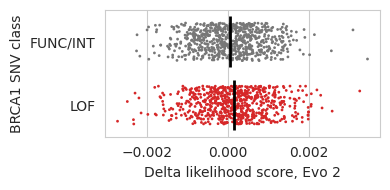

In [80]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up plot aesthetics
plt.figure(figsize=(4, 2))
sns.set_style("whitegrid")

# Plot stripplot of distributions
p = sns.stripplot(
    data=test_results,
    x='delta_score',
    y='class',
    hue='class',
    order=['FUNC/INT', 'LOF'],
    palette=['#777777', 'C3'],
    size=2,
    jitter=0.3,
)

# Mark medians from each distribution with a line
sns.boxplot(
    showmeans=True,
    meanline=True,
    meanprops={'visible': False},
    medianprops={'color': 'k', 'ls': '-', 'lw': 2},
    whiskerprops={'visible': False},
    zorder=10,
    x="delta_score",
    y="class",
    data=test_results,
    showfliers=False,
    showbox=False,
    showcaps=False,
    ax=p
)

# Add labels and adjust layout
plt.xlabel('Delta likelihood score, Evo 2')
plt.ylabel('BRCA1 SNV class')
plt.tight_layout()

# Save and display
plt.savefig('brca1_delta_scores.png', dpi=300)
plt.show()

In [86]:
def calculate_sequence_likelihood_corrected(token_logits, pad_mask):
    """Calculate log-likelihood based on original implementation."""
    # Convert to log probabilities
    log_probs = torch.log_softmax(token_logits, dim=-1)
    
    # Get most likely tokens at each position (our best approximation of input)
    input_ids = torch.argmax(token_logits, dim=-1)
    
    # Shift sequences (targets are shifted by 1 from inputs)
    targets = input_ids[:, 1:].contiguous()
    shifted_logits = log_probs[:, :-1, :].contiguous()
    shifted_mask = pad_mask[:, 1:].contiguous()
    
    # Get log probabilities for the next tokens
    gathered_log_probs = torch.gather(
        shifted_logits, 
        dim=2, 
        index=targets.unsqueeze(-1)
    ).squeeze(-1)
    
    # Apply mask
    masked_log_probs = gathered_log_probs * shifted_mask
    
    # Sum and normalize (using mean method)
    seq_sum = masked_log_probs.sum(dim=1)
    seq_length = shifted_mask.sum(dim=1)
    normalized_log_likelihood = seq_sum / seq_length
    
    return normalized_log_likelihood

In [87]:
# Calculate normalized log-likelihoods with corrected method
ref_scores = calculate_sequence_likelihood_corrected(ref_preds["token_logits"], ref_preds["pad_mask"])
var_scores = calculate_sequence_likelihood_corrected(var_preds["token_logits"], var_preds["pad_mask"])

# Convert to numpy
ref_scores_np = ref_scores.cpu().numpy()
var_scores_np = var_scores.cpu().numpy()

# Rest of mapping code remains the same...

# When calculating AUROC, try both directions
y_true = (test_results['class'] == 'LOF')
auroc_neg = roc_auc_score(y_true, -test_results['delta_score'])
auroc_pos = roc_auc_score(y_true, test_results['delta_score'])

print(f"AUROC with negative delta scores: {auroc_neg:.3f}")
print(f"AUROC with positive delta scores: {auroc_pos:.3f}")

AUROC with negative delta scores: 0.463
AUROC with positive delta scores: 0.537
